In this notebook we'll explore the solution found by our classifier.

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import utils

%load_ext autoreload
%matplotlib inline

Using TensorFlow backend.
/Users/davidbiagioni/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
%autoreload
import utils

### Re-create the training data using saved model params

In [3]:
# Pick a model to load and extract the hyperparams.

model_name = 'models/64_64_32_0.1_False_200_10000_0.1_64_002_0.20667_0.81852.h5'

gru_dim, embed_dim, dense_dim, dropout, bidirectional, maxlen, topn, test_size, batch_size = \
  utils.parse_model_name(model_name)
  
# Load the keras model
model = load_model(model_name)

In [4]:
%%time

# Load the source data frame

filepath = '../data/data-False-3.pkl'
df, keep_stops, min_sents, vocab, w2i, i2w = utils.read_dataset(filepath)

CPU times: user 31 s, sys: 620 ms, total: 31.6 s
Wall time: 31.7 s


In [5]:
%%time

# Filter out uncommon words using parameters parsed from model name.

df['encoded_text'] = utils.filter_top_words(list(df['encoded_text']), topn)

CPU times: user 1.64 s, sys: 50.7 ms, total: 1.69 s
Wall time: 1.69 s


In [6]:
# Create input/output data

X = pad_sequences(df['encoded_text'], maxlen=maxlen, value=topn, 
                  padding='post', truncating='post')

Y = df['encoded_label'].tolist()

### High-level view of data

In [67]:
counts = df['domain'].value_counts()[:30]
freq =  1. * counts / df.shape[0]
summary = pd.concat([counts, freq], axis=1)
summary.columns = ['Num articles', 'Relative Frequency']

labels = []
for idx in summary.index:
  summary.ix[idx, 'Label'] = df[df['domain'] == idx]['label'].iloc[0]

summary.to_csv('/Users/davidbiagioni/Desktop/data.csv')

In [7]:
# Get output probabilities for every observation.

df['prob'] = model.predict(X)

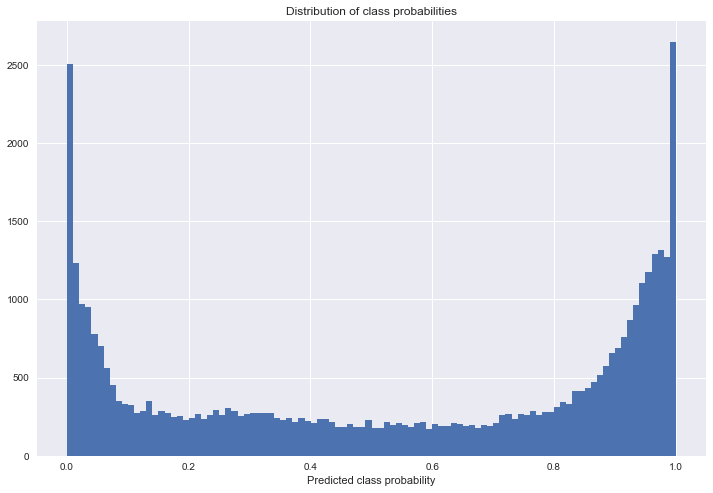

In [16]:
# Look at distribution.  There are some funny extreme modes we should try to understand.

fig, ax = plt.subplots()
ax.set_xlabel('Predicted class probability')
ax = df['prob'].hist(bins=100, figsize=(12, 8), ax=ax)
ax = ax.set_title('Distribution of class probabilities')

In [24]:
sn.color_palette()[1]

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

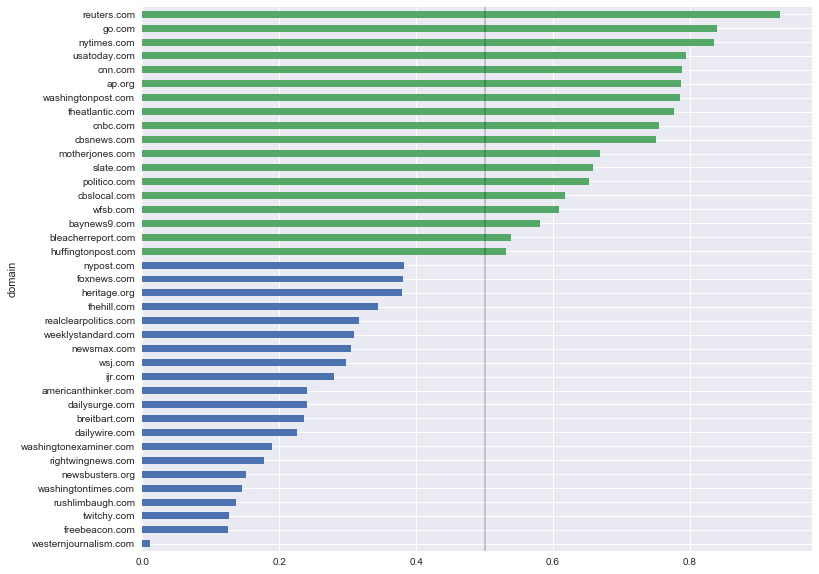

In [39]:
# Groupby domain name and take the average probability.  We can then round to 0/1 to 
# get a domain-level classification.

drop_less_than = 10  # Drop domains with fewer than this many observations

df_mean = df.groupby('domain')['encoded_label', 'prob'].mean()
df_count = df.groupby('domain')['domain'].count()
df_stats = pd.concat([df_mean, df_count], axis=1).sort_values('prob')
df_stats['num_correct'] = df_stats.apply(lambda x: int(np.round(x['prob'])) == x['encoded_label'], axis=1)
df_stats = df_stats[df_stats['domain'] >= drop_less_than]

colors = {0: sn.color_palette()[0], 1: sn.color_palette()[1]}

ax = df_stats['prob'].plot(kind='barh', figsize=(12, 10), color=[colors[i] for i in df_stats['encoded_label']])

ax = ax.axes.vlines(0.5, -19, 100, alpha=.2)

In [22]:
df_stats

,encoded_label,prob,domain,num_correct
domain,,,,
westernjournalism.com,0,0.011371,1386,True
freebeacon.com,0,0.124865,541,True
twitchy.com,0,0.125950,416,True
rushlimbaugh.com,0,0.137237,18,True
washingtontimes.com,0,0.145994,1114,True
newsbusters.org,0,0.151458,438,True
rightwingnews.com,0,0.177178,1617,True
washingtonexaminer.com,0,0.188873,1535,True
dailywire.com,0,0.225799,902,True


In [18]:
# Count the number of correct domain-level classifications.
tf = df_stats.groupby('num_correct')['prob'].count()
print('Domain-level accuracy: {:1.1f}%'.format(100.*tf[True]/tf.sum()))

Domain-level accuracy: 74.8%


In [19]:
df_stats.shape

(107, 4)